## Import Dependencies

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Fetch the datasets


In [7]:
train_data = pd.read_csv('/content/mitbih_train.csv')
test_data = pd.read_csv('/content/mitbih_test.csv')

train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data info

In [8]:
# total samples
(train_data.shape[0], test_data.shape[0])

(87553, 21891)

In [9]:
# Null values
(train_data.isna().sum().sum(), test_data.isna().sum().sum())

(0, 0)

In [10]:
# Duplicates
(train_data.duplicated().sum(), test_data.duplicated().sum())

(0, 0)

In [11]:
# No of classes and contents
train_data.iloc[:, -1].value_counts()

,count
0.000000000000000000e+00.88,
0.0,72470
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [12]:
test_classes = test_data.iloc[:, -1].unique()
train_classes = train_data.iloc[:, -1].unique()

In [13]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

## Data Preprocessing

In [14]:
# Separate features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of samples
n_test_samples = X_test_scaled.shape[0]

# Split the training data
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test_scaled, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Reshape the data
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))

## Model 1 | GRU

In [15]:
model1 = Sequential()
model1.add(GRU(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(GRU(64))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation='softmax'))

In [18]:
model1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

es = EarlyStopping(monitor="val_loss",
                    patience=3,
                    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

In [19]:
history1 = model1.fit(X_train_scaled, y_train,
                            epochs=20,
                            batch_size=64,
                            validation_data=(X_val, y_val),
                            callbacks= [es, reduce_lr, model_checkpoint])

Epoch 1/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9299 - loss: 0.2883 - val_accuracy: 0.9506 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 2/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9503 - loss: 0.1886 - val_accuracy: 0.9609 - val_loss: 0.1536 - learning_rate: 0.0010
Epoch 3/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9585 - loss: 0.1570 - val_accuracy: 0.9654 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 4/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9647 - loss: 0.1320 - val_accuracy: 0.9672 - val_loss: 0.1328 - learning_rate: 0.0010
Epoch 5/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9705 - loss: 0.1103 - val_accuracy: 0.9688 - val_loss: 0.1191 - learning_rate: 0.0010
Epoch 6/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9730 - loss: 0.1022 - val_accuracy: 0.9727 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 7/20
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accura

In [20]:
y_test_pred_gru = model1.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [21]:
gru_test_loss, gru_test_acc = model1.evaluate(X_test_new, y_test_new, verbose=0)
print(f"GRU Test Loss: {gru_test_loss:.4f}")
print(f"GRU Test Accuracy: {gru_test_acc:.4f}")

GRU Test Loss: 0.0555
GRU Test Accuracy: 0.9845


In [22]:
class_names = [labels[i] for i in range(len(labels))]

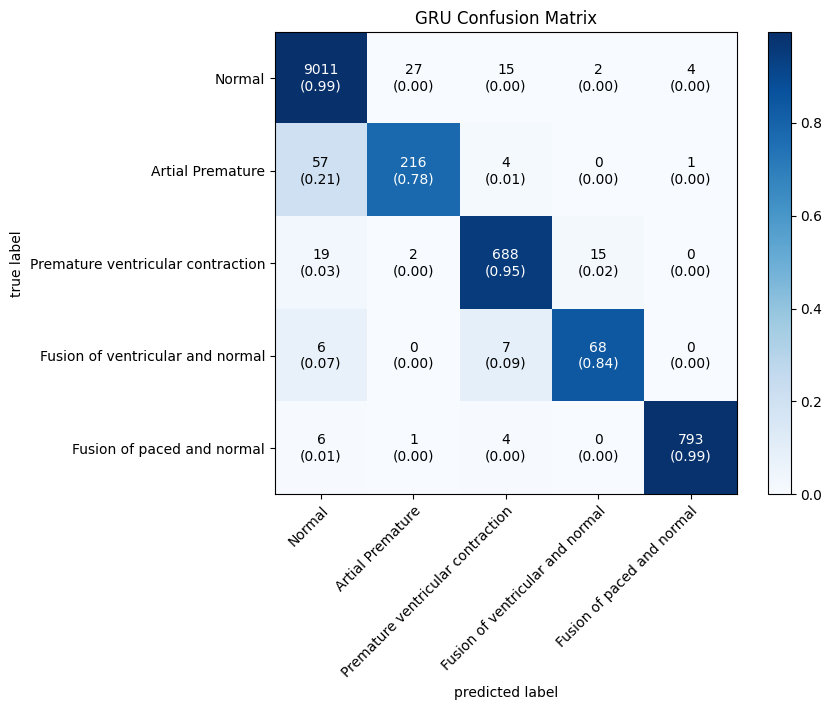

In [23]:
conf_matrix_gru = confusion_matrix(y_test_new, y_test_pred_gru)

plot_confusion_matrix(conf_matrix_gru,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('GRU Confusion Matrix')
plt.show()

In [41]:
print(classification_report(y_test_new, y_test_pred_gru))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9059
         1.0       0.88      0.78      0.82       278
         2.0       0.96      0.95      0.95       724
         3.0       0.80      0.84      0.82        81
         4.0       0.99      0.99      0.99       804

    accuracy                           0.98     10946
   macro avg       0.92      0.91      0.92     10946
weighted avg       0.98      0.98      0.98     10946



## Model 2 | LSTM

In [24]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))

In [29]:
model2.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

hisotry2 = model2.fit(X_train_scaled, y_train,
                            epochs=10,
                            batch_size=64,
                            validation_data=(X_val, y_val),
                            callbacks= [reduce_lr, model_checkpoint])

Epoch 1/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8790 - loss: 0.4243 - val_accuracy: 0.9238 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 2/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8992 - loss: 0.3773 - val_accuracy: 0.9261 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 3/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9251 - loss: 0.2950 - val_accuracy: 0.9315 - val_loss: 0.2578 - learning_rate: 0.0010
Epoch 4/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9338 - loss: 0.2532 - val_accuracy: 0.9401 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 5/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9391 - loss: 0.2269 - val_accuracy: 0.9424 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 6/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9426 - loss: 0.2089 - val_accuracy: 0.9524 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 7/10
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accura

In [30]:
y_test_pred_lstm = model2.predict(X_test_new).argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [31]:
lstm_test_loss, lstm_test_acc = model2.evaluate(X_test_new, y_test_new, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f}")

LSTM Test Loss: 0.1297
LSTM Test Accuracy: 0.9667


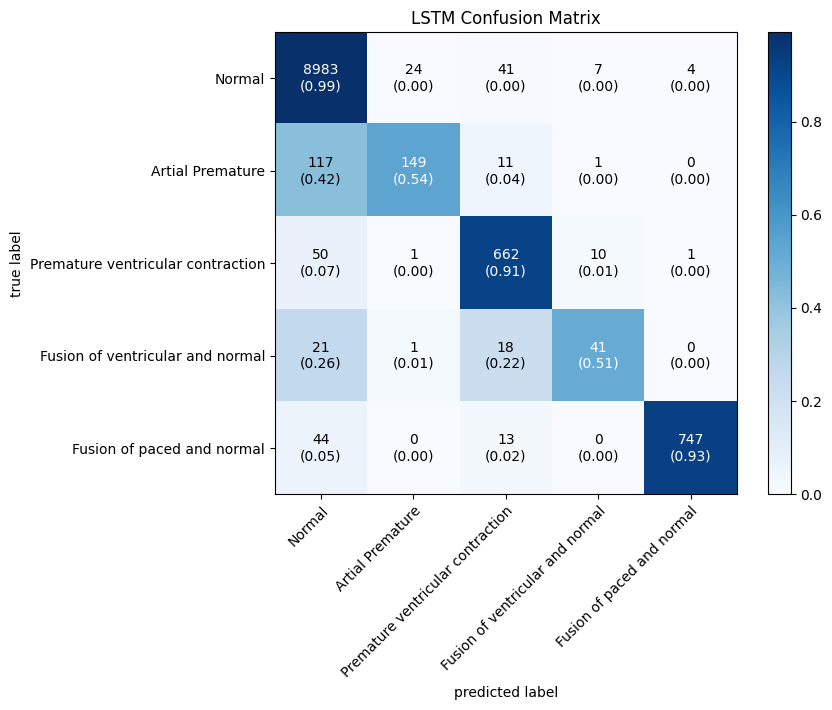

In [32]:
conf_matrix_lstm = confusion_matrix(y_test_new, y_test_pred_lstm)

plot_confusion_matrix(conf_matrix_lstm,
                      class_names=class_names,
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.title('LSTM Confusion Matrix')
plt.show()

In [42]:
print(classification_report(y_test_new, y_test_pred_lstm))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9059
         1.0       0.85      0.54      0.66       278
         2.0       0.89      0.91      0.90       724
         3.0       0.69      0.51      0.59        81
         4.0       0.99      0.93      0.96       804

    accuracy                           0.97     10946
   macro avg       0.88      0.78      0.82     10946
weighted avg       0.97      0.97      0.96     10946



## Model Comparison

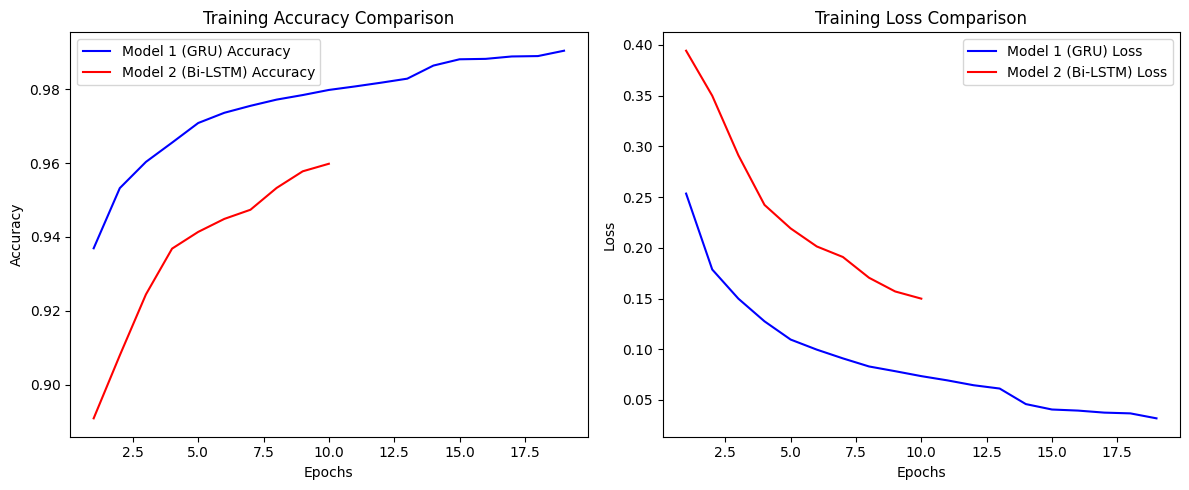

In [36]:
import matplotlib.pyplot as plt

accuracy1 = history1.history['accuracy']
loss1 = history1.history['loss']
accuracy2 = hisotry2.history['accuracy']
loss2 = hisotry2.history['loss']

epochs1 = range(1, len(accuracy1) + 1)
epochs2 = range(1, len(accuracy2) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs1, accuracy1, 'b', label='Model 1 (GRU) Accuracy')
plt.plot(epochs2, accuracy2, 'r', label='Model 2 (Bi-LSTM) Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs1, loss1, 'b', label='Model 1 (GRU) Loss')
plt.plot(epochs2, loss2, 'r', label='Model 2 (Bi-LSTM) Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()